# Wrapping up our CNN

First of all, don't worry: this is meant to take a while!

Also we cover software engineering because we think that data scientists should be good software engineers.

Today we're going to start to move from a minimal training loop to something that is SoTA on ImageNet, things we'll cover:

- Cuda
- Convolutions
- Hooks
- Normalization
- Transforms
- Data Blocks
- Label Smoothing
- Optimization
- Weight Decay
- Skip Connection Architectures

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

## Callbacks

### Callbacks as GUI events

In [4]:
import ipywidgets as widgets

In [5]:
def f(o):
    print('hi')

In [6]:
w = widgets.Button(description='Click Me')

In [7]:
w

Button(description='Click Me', style=ButtonStyle())

In [8]:
w.on_click(f)

Meaning, when a click event occurs, **callback** to the function f.

### Creating Your Own Callback

In [9]:
from time import sleep

In [10]:
def slow_calculation():
    res = 0
    for i in range(5):
        res += i*i
        sleep(1)
    return res

In [11]:
slow_calculation()

30

Imagine yourself training a deep learning model, you really want to know how it's going. We simulated slow loops by writing `slow_calculation()` and now we're going to inject a call back to check how it's doing while running:

In [12]:
def slow_calculation(cb=None):
    res = 0
    for i in range(5):
        res += i*i
        sleep(1)
        if cb:
            cb(i)
    return res

In [13]:
def show_progress(epoch):
    print(f"Awesome! We've finished epoch {epoch}!")

In [14]:
slow_calculation(show_progress)

Awesome! We've finished epoch 0!
Awesome! We've finished epoch 1!
Awesome! We've finished epoch 2!
Awesome! We've finished epoch 3!
Awesome! We've finished epoch 4!


30

### Lambdas & Partials

In [15]:
slow_calculation(lambda epoch: print(f"Awesome! We've finished epoch {epoch}!"))

Awesome! We've finished epoch 0!
Awesome! We've finished epoch 1!
Awesome! We've finished epoch 2!
Awesome! We've finished epoch 3!
Awesome! We've finished epoch 4!


30

In [16]:
def show_progress(exclamation, epoch):
    print(f"{exclamation} We've finished epoch {epoch}!")

In [17]:
slow_calculation(lambda epoch: show_progress("OK I guess", epoch))

OK I guess We've finished epoch 0!
OK I guess We've finished epoch 1!
OK I guess We've finished epoch 2!
OK I guess We've finished epoch 3!
OK I guess We've finished epoch 4!


30

In [18]:
def make_show_progress(exclamation):
    _inner = lambda epoch: print(f"{exclamation}! We've finished epoch {epoch}!")
    return _inner

In [19]:
slow_calculation(make_show_progress("Nice"))

Nice! We've finished epoch 0!
Nice! We've finished epoch 1!
Nice! We've finished epoch 2!
Nice! We've finished epoch 3!
Nice! We've finished epoch 4!


30

You might see it done like this instead:

In [20]:
def make_show_progress(exclamation):
    def _inner(epoch):
        print(f"{exclamation}! We've finished epoch {epoch}!")
    return _inner

In [21]:
slow_calculation(make_show_progress("Nice"))

Nice! We've finished epoch 0!
Nice! We've finished epoch 1!
Nice! We've finished epoch 2!
Nice! We've finished epoch 3!
Nice! We've finished epoch 4!


30

In [22]:
slow_calculation(make_show_progress("Amazing"))

Amazing! We've finished epoch 0!
Amazing! We've finished epoch 1!
Amazing! We've finished epoch 2!
Amazing! We've finished epoch 3!
Amazing! We've finished epoch 4!


30

Because this feature is used soo much, python has `partials`:

In [23]:
from functools import partial

In [24]:
slow_calculation(partial(show_progress, "OK I guess"))

OK I guess We've finished epoch 0!
OK I guess We've finished epoch 1!
OK I guess We've finished epoch 2!
OK I guess We've finished epoch 3!
OK I guess We've finished epoch 4!


30

In [25]:
f2 = partial(show_progress, "OK I guess")

In [26]:
slow_calculation(f2)

OK I guess We've finished epoch 0!
OK I guess We've finished epoch 1!
OK I guess We've finished epoch 2!
OK I guess We've finished epoch 3!
OK I guess We've finished epoch 4!


30

### Callbacks as Callable Classes

In [27]:
class ProgressShowingCallback():
    def __init__(self, exclamation="Awesome"):
        self.exclamation = exclamation
    
    def __call__(self, epoch):
        print(f"{self.exclamation}! We've finished epoch {epoch}!")

In [28]:
cb = ProgressShowingCallback("Just Super")

In [29]:
slow_calculation(cb)

Just Super! We've finished epoch 0!
Just Super! We've finished epoch 1!
Just Super! We've finished epoch 2!
Just Super! We've finished epoch 3!
Just Super! We've finished epoch 4!


30

### Multiple callback funcs; `*args` and `**kwargs`

In [30]:
def f(*args, **kwargs):
    print(f"args: {args}; kwargs: {kwargs}")

In [31]:
f(3, 'a', thing1='Hello')

args: (3, 'a'); kwargs: {'thing1': 'Hello'}


In [32]:
def slow_calculation(cb=None):
    res = 0
    for i in range(5):
        if cb:
            cb.before_calc(i)
        res += i*i
        sleep(1)
        if cb:
            cb.after_calc(i, val=res)
    return res

Let's create a callback class for the function:

In [33]:
class PrintStepCallBack():
    def __init__(self):
        pass
    
    def before_calc(self, *args, **kwargs):
        print(f"About to start")
    
    def after_calc(self, *args, **kwargs):
        print(f"Done step")

In [34]:
slow_calculation(PrintStepCallBack())

About to start
Done step
About to start
Done step
About to start
Done step
About to start
Done step
About to start
Done step


30

In the previous example we didn't get an error because we used `*args` and `**kwargs`, effectively ignoring the passed parameters.

Let's now use them:

In [35]:
class PrintStatusCallBack():
    def __init__(self):
        pass
    
    def before_calc(self, epoch, **kwargs):
        print(f"About to start: {epoch}")
    
    def after_calc(self, epoch, val, **kwargs):
        print(f"Done step {epoch}: {val}")

In [36]:
slow_calculation(PrintStatusCallBack())

About to start: 0
Done step 0: 0
About to start: 1
Done step 1: 1
About to start: 2
Done step 2: 5
About to start: 3
Done step 3: 14
About to start: 4
Done step 4: 30


30

`**kwargs` are kept because we might add other parameters in the future and we don't want to break if the user added non-existing parameters, it makes the class more resilient.

### Modifying Behavior

In [37]:
def slow_calculation(cb=None):
    res = 0
    for i in range(5):
        if cb and hasattr(cb, "before_calc"):
            cb.before_calc(i)
        res += i*i
        sleep(1)
        if cb and hasattr(cb, "after_calc"):
            if cb.after_calc(i, val=res):
                print("Stopping early")
                break
    return res

In [38]:
class PrintAfterCallBack():
    def after_calc(self, epoch, val, **kwargs):
        print(f"Done step {epoch}: {val}")
        if val > 10:
            return True

In [39]:
slow_calculation(PrintAfterCallBack())

Done step 0: 0
Done step 1: 1
Done step 2: 5
Done step 3: 14
Stopping early


14

Next, we want to alter the calculation itself:

In [40]:
class SlowCalculator():
    def __init__(self, cb=None):
        self.cb = cb
        self.res = 0
    
    def callback(self, cb_name, *args):
        if not self.cb:
            return
        cb = getattr(self.cb, cb_name, None)
        if cb:
            return cb(self, *args)
    
    def calc(self):
        for i in range(5):
            self.callback('before_calc', i)
            self.res += i*i
            sleep(1)
            if self.callback('after_calc', i):
                print("Stopping Early")
                break

In [41]:
class ModifyingCallBack():
    def after_calc(self, calc, epoch):
        print(f"After epoch {epoch}: {calc.res}")
        if calc.res > 10:
            return True
        if calc.res < 3:
            calc.res = calc.res*2

In [42]:
calculator = SlowCalculator(ModifyingCallBack())

In [43]:
calculator.calc()

After epoch 0: 0
After epoch 1: 1
After epoch 2: 6
After epoch 3: 15
Stopping Early


This represent the extend of our callback functionalities that we use in FastAI.

### `__dunder__` thingies

In [44]:
class SloppyAdder():
    def __init__(self, o):
        self.o = o
    
    def __add__(self, b):
        return SloppyAdder(self.o + b.o + 0.01)
    
    def __repr__(self):
        return str(self.o)

In [45]:
a = SloppyAdder(1)
b = SloppyAdder(2)
a + b

3.01

Special Methods I should know:

- [x] __getitem__
- [ ] __getattr__
- [ ] __setattr__
- [ ] __del__
- [x] __init__
- [ ] __new__
- [ ] __enter__
- [ ] __exit__
- [x] __len__
- [x] __repr__
- [ ] __str__

## Browsing Source Code

Learn to do these things in our editor of choice:

- [ ] Jump to tag/symbol by with (with completion)
    - Symbol: class/fucntion/...
- [ ] Jump to current tag
    - By clicking on the tag
- [ ] Jump to library tags
- [ ] Go back
    - To the place you were working in (in the file)
- [ ] Search
- [ ] Outlining/Folding

## Variance & Stuff

### Variance

Variance is the average of how far each data point is from the mean $\mu$.

In [46]:
t = torch.Tensor([1., 2., 4., 18.])

In [47]:
m = t.mean(); m

tensor(6.2500)

In [48]:
(t-m).mean()

tensor(0.)

We can't do that because all of the negative/positive differences cancel-out, so we can fix that in one of two ways:

In [49]:
(t-m).pow(2).mean()

tensor(47.1875)

The **mean absolute deviation**:

In [50]:
# Or..
(t-m).abs().mean()

tensor(5.8750)

Let's undo the squaring that happened for the first solution, we present the **standard deviation**:

In [51]:
(t-m).pow(2).mean().sqrt()

tensor(6.8693)

they're still different, why?

Because of the squaring mechanism, standard deviation is more sensitive to outliers.

Here's a useful thing to note about variance:

In [52]:
(t-m).pow(2).mean(), (t*t).mean() - (m*m)

(tensor(47.1875), tensor(47.1875))

Or:

$$Var(X)=\frac{1}{m}\sum_{i=1}^{m}x_{i}^{2}-\mu^2=E[X^2]-E[X]^2$$

The important thing is that this formula is much more easier to work with. In particular, you only have to track two things:

1. The sum of the data
2. The sum of squares of the data

Whereas in the original formula you have to go through all of the data twice, once to calculate the mean & once to calculate the variance.

### Covariance & Correlation 

Here's how wikipedia defines covariance:

$$Cov(X,Y)=E[(X-E[X])(Y-E[Y])]$$

In [53]:
t

tensor([ 1.,  2.,  4., 18.])

Let's see that in code, So now we need two vectors:

In [54]:
# `u` is twice as `t` plus a little bit of randomness
u = t * 2 
u += torch.randn_like(t)/10+0.95

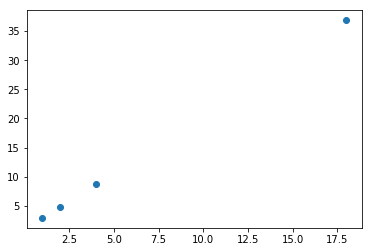

In [55]:
plt.scatter(t, u)

In [56]:
prod = (t-t.mean())*(u-u.mean())
prod

tensor([ 54.6310,  36.4790,  10.1660, 276.2119])

In [57]:
prod.mean()

tensor(94.3720)

Let's compare the previous average with the next:

In [58]:
v = torch.randn_like(t)

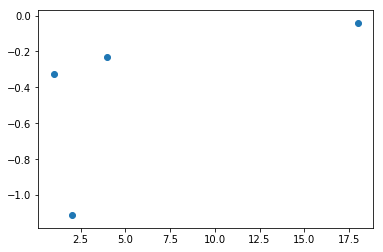

In [59]:
plt.scatter(t, v)

In [60]:
prod = (t-t.mean())*(v-v.mean())
prod

tensor([-0.5332,  2.9161, -0.4431,  4.5549])

In [61]:
prod.mean()

tensor(1.6237)

Covariance tells you how random variables vary jointly, you can also calculate it as follows:

$$Cov(X,Y)=E[XY]-E[X]E[Y]$$

In [62]:
cov = (t*u).mean() - (t.mean()*u.mean())
cov

tensor(94.3720)

Finally, here is the pearson correlation coefficient:

$$p_{X,Y}=\frac{Cov(X,Y)}{\sigma_{X}\sigma_{Y}}$$

In [63]:
cov / (t.std() * u.std())

tensor(0.7500)

This is just a scaled version so that the output is $\in [-1,1]$.

Remember that Covariance and its pearson coefficient describe **linear** variations.

## Softmax

Here's our final `logsoftmax` definition:

In [64]:
def log_softmax(x):
    return x - x.exp().sum(-1, keepdim=True).log()

Which is:

$$logsoftmax(x)_i=x_i - log\sum_{j}e^{x_j}$$

And our cross entropy loss is:

$$-log(p_i)$$

A big problem with softmax is that it **must** pick something, so even if the activation values of the last layer are negative (signaling the absence of all classes from an example image) the softmax function will force a probability distribution that sum up to one so that a class can be picked.

Another problem that happens is when you have multiple classes present in the image, in this case even the present classes will get minimized by the softmax function in favor of the class associated with the highest activation to be picked.

Meaning, softmax is terrible except if you definately know that, per image, you have only one and no more or less than one "class" present in the image.

If your not sure, use this:

$$S(x)=\frac{e^x}{1+{e^x}}$$

And because, for the most part, you won't be sure, **don't use softmax**. 

---

# Early Stopping


## Better callback cancelation

In [65]:
from fastai import datasets
from torch import tensor
from torch.utils.data import Dataset, DataLoader
import gzip, pickle
from torch import optim
import re

In [66]:
def get_data(MNIST_URL = 'http://deeplearning.net/data/mnist/mnist.pkl'):
    path = datasets.download_data(MNIST_URL, ext='.gz')
    with gzip.open(path, 'rb') as f:
        ((X_train, y_train), (X_val, y_val), _) = pickle.load(f, encoding='latin-1')
    return map(tensor, (X_train, y_train, X_val, y_val))

def normalize(x, m, s):
    return (x-m)/s

In [67]:
X_train, y_train, X_valid, y_valid = get_data()

In [68]:
datasets.download_data??

In [69]:
class Dataset():
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [70]:
train_ds, val_ds = Dataset(X_train, y_train), Dataset(X_valid, y_valid)

In [71]:
nh, bs = 50, 512

In [72]:
c = y_train.max().item() + 1

In [73]:
loss_func = F.cross_entropy

In [74]:
def get_dls(train_ds, valid_ds, bs, **kwargs):
    """Returns the dataloaders for both the training and validation sets"""
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))


class DataBunch():
    def __init__(self, train_dl, val_dl, c=None):
        self.train_dl, self.val_dl, self.c = train_dl, val_dl, c
    
    @property
    def train_ds(self):
        return self.train_dl.dataset
    
    @property
    def valid_ds(self):
        return self.val_dl.dataset

In [75]:
data = DataBunch(*get_dls(train_ds, val_ds, bs), c)

In [76]:
class Callback():
    _order=0
    def set_runner(self, run): self.run=run
    def __getattr__(self, k): return getattr(self.run, k)
    @property
    def name(self):
        name = re.sub(r'Callback$', '', self.__class__.__name__)
        return camel2snake(name or 'callback')
    
    def __call__(self, cb_name):
        f = getattr(self, cb_name, None)
        if f and f():
            return True
        return False

class TrainEvalCallback(Callback):
    def begin_fit(self):
        self.run.n_epochs=0.
        self.run.n_iter=0
    
    def after_batch(self):
        if not self.in_train: return
        self.run.n_epochs += 1./self.iters
        self.run.n_iter   += 1
        
    def begin_epoch(self):
        self.run.n_epochs=self.epoch
        self.model.train()
        self.run.in_train=True

    def begin_validate(self):
        self.model.eval()
        self.run.in_train=False
        
class CancelTrainException(Exception):
    pass
class CancelEpochException(Exception):
    pass
class CancelBatchException(Exception):
    pass

In [77]:
class Runner():
    def __init__(self, cbs=None, cb_funcs=None):
        cbs = listify(cbs)
        for cbf in listify(cb_funcs):
            cb = cbf()
            setattr(self, cb.name, cb)
            cbs.append(cb)
        self.stop,self.cbs = False,[TrainEvalCallback()]+cbs

    @property
    def opt(self):       return self.learn.opt
    @property
    def model(self):     return self.learn.model
    @property
    def loss_func(self): return self.learn.loss_func
    @property
    def data(self):      return self.learn.data

    def one_batch(self, xb, yb):
        self.xb,self.yb = xb,yb
        if self('begin_batch'): return
        self.pred = self.model(self.xb)
        if self('after_pred'): return
        self.loss = self.loss_func(self.pred, self.yb)
        if self('after_loss') or not self.in_train: return
        self.loss.backward()
        if self('after_backward'): return
        self.opt.step()
        if self('after_step'): return
        self.opt.zero_grad()

    def all_batches(self, dl):
        self.iters = len(dl)
        for xb,yb in dl:
            if self.stop: break
            self.one_batch(xb, yb)
            self('after_batch')
        self.stop=False
        
    def fit(self, epochs, learn):
        self.epochs,self.learn = epochs,learn

        try:
            for cb in self.cbs: cb.set_runner(self)
            if self('begin_fit'): return
            for epoch in range(epochs):
                self.epoch = epoch
                if not self('begin_epoch'): self.all_batches(self.data.train_dl)

                with torch.no_grad(): 
                    if not self('begin_validate'): self.all_batches(self.data.val_dl)
                if self('after_epoch'): break

        except CancelTrainException:
            self('after_cancel_train')
        finally:
            self('after_fit')
            self.learn = None

    def __call__(self, cb_name):
        for cb in sorted(self.cbs, key=lambda x: x._order):
            f = getattr(cb, cb_name, None)
            if f and f(): return True
        return False

In [78]:
def create_learner(model_func, loss_func, data):
    return Learner(*model_func(data), loss_func, data)

def get_model(data, lr=0.5, nh=50):
    n = data.train_ds.x.shape[1]
    model = nn.Sequential(nn.Linear(n, nh), nn.ReLU(), nn.Linear(nh, data.c))
    return model, optim.SGD(model.parameters(), lr=lr)

class Learner():
    def __init__(self, model, opt, loss_func, data):
        self.model, self.opt, self.loss_func, self.data = model, opt, loss_func, data

In [79]:
learn = create_learner(get_model, loss_func, data)

In [80]:
from typing import *

def listify(o):
    if o is None: return []
    if isinstance(o, list): return o
    if isinstance(o, str): return [o]
    if isinstance(o, Iterable): return list(o)
    return [o]

class TestCallBack(Callback):
    _order=1
    
    def after_step(self):
        print(self.n_iter)
        if self.n_iter >= 10:
            raise CancelTrainException()

In [81]:
_camel_re1 = re.compile('(.)([A-Z][a-z]+)')
_camel_re2 = re.compile('([a-z0-9])([A-Z])')
def camel2snake(name):
    s1 = re.sub(_camel_re1, r'\1_\2', name)
    return re.sub(_camel_re2, r'\1_\2', s1).lower()

In [82]:
run = Runner(cb_funcs=TestCallBack)

In [83]:
run.fit(3, learn)

0
1
2
3
4
5
6
7
8
9
10


## Other Callbacks

### LR Finder

In [84]:
class LR_Find(Callback):
    _order = 1
    def __init__(self, max_iter=100, min_lr=1e-6, max_lr=10):
        self.max_iter, self.min_lr, self.max_lr = max_iter, min_lr, max_lr
        self.best_loss = 1e9
    
    def begin_batch(self):
        if not self.in_train:
            return
        pos = self.n_iter/self.max_iter
        lr = self.min_lr * (self.max_lr/self.min_lr) ** pos
        for pg in self.opt.param_groups:
            pg['lr'] = lr
    
    def after_step(self):
        if self.n_iter >= self.max_iter or self.loss > self.best_loss * 10:
            raise CancelTrainException()
        if self.loss < self.best_loss:
            self.best_loss = self.loss


class Recorder(Callback):
    def begin_fit(self): self.lrs,self.losses = [],[]

    def after_batch(self):
        if not self.in_train: return
        self.lrs.append(self.opt.param_groups[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self): plt.plot(self.lrs)
    def plot_loss(self): plt.plot(self.losses)

In [85]:
learn = create_learner(get_model, loss_func, data)

In [86]:
run = Runner(cb_funcs=[LR_Find, Recorder])

In [87]:
run.fit(2, learn)

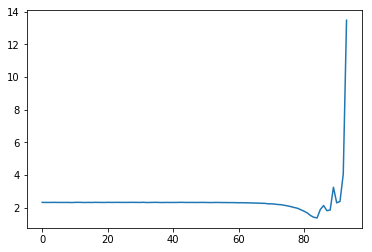

In [88]:
run.recorder.plot_loss()

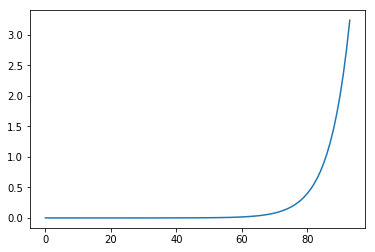

In [89]:
run.recorder.plot_lr()

---

# ConvNet

In [90]:
X_train, y_train, X_val, y_val = get_data()

Helper function to quickly normalize with the mean and standard deviation of our training set:

In [91]:
def normalize_to(train, valid):
    m, s = train.mean(), train.std()
    return normalize(train, m, s), normalize(valid, m, s)

In [92]:
X_train, X_val = normalize_to(X_train, X_valid)
train_ds, val_ds = Dataset(X_train, y_train), Dataset(X_val, y_val)

In [93]:
X_train.mean(), X_train.std(), X_val.mean(), X_val.std()

(tensor(-3.0466e-06), tensor(1.), tensor(-0.0059), tensor(0.9924))

In [94]:
nh, bs = 50, 512

In [95]:
c = y_train.max().item() + 1

In [96]:
loss_func = F.cross_entropy

In [97]:
data = DataBunch(*get_dls(train_ds, val_ds, bs), c)

To refactor layers, It's useful to have a Lambda layer that can take a basic function and convert it to a layer you can put in `nn.Sequential`.

In [98]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
    
    def forward(self, x):
        return self.func(x)

def flatten(x):
    return x.view(x.shape[0], -1)

In [99]:
def mnist_resize(x):
    return x.view(-1, 1, 28, 28)

We can now define a simple CNN:

In [100]:
def get_cnn_model(data):
    return nn.Sequential(
        Lambda(mnist_resize),
        nn.Conv2d(1, 8, 5, padding=2, stride=2), nn.ReLU(),
        nn.Conv2d(8, 16, 3, padding=1, stride=2), nn.ReLU(),
        nn.Conv2d(16, 32, 3, padding=1, stride=2), nn.ReLU(),
        nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten),
        nn.Linear(32, data.c)
    )

In [101]:
model = get_cnn_model(data)

Let's get our callback functions:

In [102]:
class AvgStats():
    def __init__(self, metrics, in_train): 
        self.metrics, self.in_train = listify(metrics), in_train
    
    def reset(self):
        self.tot_loss,self.count = 0.,0
        self.tot_mets = [0.] * len(self.metrics)
        
    @property
    def all_stats(self): 
        return [self.tot_loss.item()] + self.tot_mets
    
    @property
    def avg_stats(self): 
        return [o/self.count for o in self.all_stats]
    
    def __repr__(self):
        if not self.count: return ""
        return f"{'train' if self.in_train else 'valid'}: {self.avg_stats}"

    def accumulate(self, run):
        bn = run.xb.shape[0]
        self.tot_loss += run.loss * bn
        self.count += bn
        for i,m in enumerate(self.metrics):
            self.tot_mets[i] += m(run.pred, run.yb) * bn


class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats, self.valid_stats = AvgStats(metrics, True), AvgStats(metrics, False)
        
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
        
    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run)
    
    def after_epoch(self):
        print(self.train_stats)
        print(self.valid_stats)

def accuracy(out, yb):
    return (torch.argmax(out, dim=1) == yb).float().mean()

In [103]:
cbfs = [Recorder, partial(AvgStatsCallback, accuracy)]

In [104]:
opt = optim.SGD(model.parameters(), lr=0.4)

In [105]:
learn = Learner(model, opt, loss_func, data)

In [106]:
run = Runner(cb_funcs=cbfs)

In [107]:
%time run.fit(1, learn)

train: [2.01694859375, tensor(0.2951)]
valid: [1.0925693359375, tensor(0.6162)]
CPU times: user 15.5 s, sys: 27.1 s, total: 42.6 s
Wall time: 5.91 s


## CUDA

This took a long time to run, It's time to use a GPUs.

A simple callback can make sure the model, inputs, and targets are all on the same device.

In [108]:
device = torch.device('cuda', 0)

In [109]:
class CudaCallBack(Callback):
    def __init__(self, device):
        self.device = device
    
    def begin_fit(self):
        self.model.to(self.device)
    
    def begin_batch(self):
        self.run.xb, self.run.yb = self.xb.to(self.device), self.yb.to(self.device)

In [110]:
# Somewhat less flexible, but quite convenient
torch.cuda.set_device(device)

In [111]:
class CudaCallBack(Callback):
    def begin_fit(self):
        self.model.cuda()
    
    def begin_batch(self):
        self.run.xb, self.run.yb = self.xb.cuda(), self.yb.cuda()

In [112]:
cbfs.append(CudaCallBack)

In [113]:
model = get_cnn_model(data)

In [114]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [115]:
%time run.fit(3, learn)

train: [2.093578125, tensor(0.2432, device='cuda:0')]
valid: [1.6709130859375, tensor(0.4680, device='cuda:0')]
train: [0.5412753515625, tensor(0.8273, device='cuda:0')]
valid: [0.2072068603515625, tensor(0.9403, device='cuda:0')]
train: [0.20172669921875, tensor(0.9391, device='cuda:0')]
valid: [0.1400499755859375, tensor(0.9577, device='cuda:0')]
CPU times: user 4.89 s, sys: 992 ms, total: 5.88 s
Wall time: 5.92 s


## Refactor Model

first we can regroup all of the conv/relu into a single function:

In [116]:
def conv2d(ni, nf, ks=3, stride=2):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), nn.ReLU())

In [117]:
class BatchTransformXCallback(Callback):
    _order=2
    def __init__(self, tfm): self.tfm = tfm
    def begin_batch(self): self.run.xb = self.tfm(self.xb)

def view_tfm(*size):
    def _inner(x): return x.view(*((-1,)+size))
    return _inner

In [118]:
mnist_view = view_tfm(1,28,28)
cbfs.append(partial(BatchTransformXCallback, mnist_view))

In [119]:
nfs = [8,16,32,32]

In [120]:
def get_cnn_layers(data, nfs):
    nfs = [1] + nfs
    return [
        conv2d(nfs[i], nfs[i+1], 5 if i==0 else 3)
        for i in range(len(nfs)-1)
    ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def get_cnn_model(data, nfs): return nn.Sequential(*get_cnn_layers(data, nfs))

In [121]:
def get_runner(model, data, lr=0.6, cbs=None, opt_func=None, loss_func = F.cross_entropy):
    if opt_func is None: opt_func = optim.SGD
    opt = opt_func(model.parameters(), lr=lr)
    learn = Learner(model, opt, loss_func, data)
    return learn, Runner(cb_funcs=listify(cbs))

In [122]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.4, cbs=cbfs)

In [123]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=10, bias=True)
)

In [124]:
run.fit(3, learn)

train: [2.1856284375, tensor(0.1983, device='cuda:0')]
valid: [1.62301279296875, tensor(0.5182, device='cuda:0')]
train: [0.75375609375, tensor(0.7618, device='cuda:0')]
valid: [0.288960205078125, tensor(0.9110, device='cuda:0')]
train: [0.245807734375, tensor(0.9241, device='cuda:0')]
valid: [0.1788814208984375, tensor(0.9489, device='cuda:0')]


## Hooks

Our next goal is to see what's "going on inside the model"!

### Manual Insertion

In [125]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds  = [[] for _ in layers]
        
    def __call__(self, x):
        for i,l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(x.data.mean())
            self.act_stds [i].append(x.data.std ())
        return x
    
    def __iter__(self): 
        return iter(self.layers)

In [126]:
model =  SequentialModel(*get_cnn_layers(data, nfs))
learn, run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [127]:
run.fit(2, learn)

train: [2.36338, tensor(0.1185, device='cuda:0')]
valid: [2.3014935546875, tensor(0.1064, device='cuda:0')]
train: [2.015745, tensor(0.2740, device='cuda:0')]
valid: [1.50768828125, tensor(0.4716, device='cuda:0')]


Now we can have a look at the means and stds of the activations at the beginning of training.

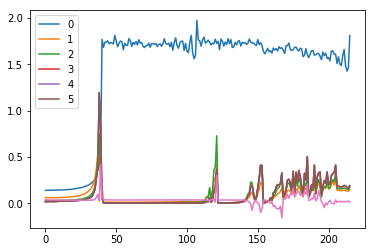

In [128]:
for l in model.act_means: 
    plt.plot(l)
plt.legend(range(6));

This is somewhat bad because we have sharp vibrations, ideally we want the means to be smooth and near $0$. Let's try to change that.

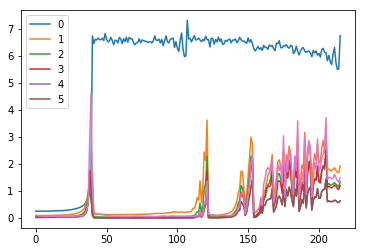

In [129]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(6));

Let's look at the first 10 batches for each layer at each step:

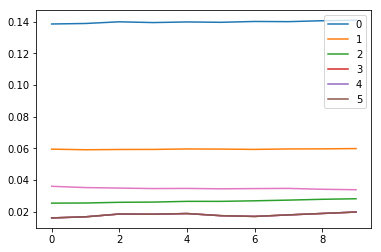

In [130]:
for l in model.act_means: plt.plot(l[:10])
plt.legend(range(6));

Looks good, fairly close to 0.

Let's also take a look at the standard deviation of all layers for their 10 first batches of training: 

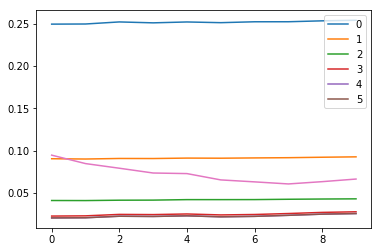

In [131]:
for l in model.act_stds: 
    plt.plot(l[:10])
plt.legend(range(6));

This is not good, the first layers `std`s are somewhat close to $1$ but all other layers are very close to 0.

We have an idea on how to solve this problem, we have to use good initialization techniques.

### PyTorch Hooks

Hooks are PyTorch objects you can add to any `nn.Module`. A Hook will be called when the layer it is registered to, is executed during the forward or backward passes.

Hooks don't require us to re-write the model.

In [132]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [133]:
act_means = [[] for _ in model]
act_stds  = [[] for _ in model]

A hook is attached to a layer, and needs to have a function that takes three arguments: **module, input, output**.

Here we store the mean and standard deviation of the output in the correct position of our list.

In [134]:
def append_stats(i, mod, inp, outp):
    act_means[i].append(outp.data.mean())
    act_stds [i].append(outp.data.std())

In [135]:
for i, m in enumerate(model): 
    m.register_forward_hook(partial(append_stats, i))

In [136]:
run.fit(1, learn)

train: [2.06755140625, tensor(0.2570, device='cuda:0')]
valid: [0.8275548828125, tensor(0.7102, device='cuda:0')]


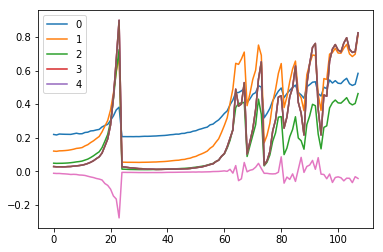

In [137]:
for o in act_means: plt.plot(o)
plt.legend(range(5));

### Hook Class

In [138]:
def children(m): 
    return list(m.children())

class Hook():
    def __init__(self, m, f): 
        self.hook = m.register_forward_hook(partial(f, self))
    
    def remove(self): 
        self.hook.remove()
    
    def __del__(self): 
        self.remove()

def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): 
        hook.stats = ([],[])
    
    means, stds = hook.stats
    means.append(outp.data.mean())
    stds.append(outp.data.std())

In [139]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [140]:
hooks = [Hook(l, append_stats) for l in children(model[:4])]

In [141]:
run.fit(1, learn)

train: [1.809714375, tensor(0.3575, device='cuda:0')]
valid: [0.574386962890625, tensor(0.7817, device='cuda:0')]


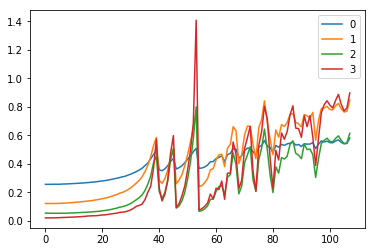

In [142]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(4));

### A Hooks Class

In [143]:
class ListContainer():
    def __init__(self, items): 
        self.items = listify(items)
    
    def __getitem__(self, idx):
        if isinstance(idx, (int,slice)): 
            return self.items[idx]
        
        if isinstance(idx[0],bool):
            assert len(idx)==len(self) # bool mask
            return [o for m,o in zip(idx,self.items) if m]
        return [self.items[i] for i in idx]
    
    def __len__(self): 
        return len(self.items)
    def __iter__(self): 
        return iter(self.items)
    def __setitem__(self, i, o): 
        self.items[i] = o
    def __delitem__(self, i): 
        del(self.items[i])
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self)>10: res = res[:-1]+ '...]'
        return res

In [144]:
ListContainer(range(10))

ListContainer (10 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [145]:
ListContainer(range(100))

ListContainer (100 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9...]

In [146]:
t = ListContainer(range(10))
t[[1,2]], t[[False]*8 + [True,False]]

([1, 2], [8])

In [147]:
from torch.nn import init

class Hooks(ListContainer):
    def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms])
    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.remove()
    def __del__(self): self.remove()

    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
        
    def remove(self):
        for h in self: h.remove()

In [148]:
model = get_cnn_model(data, nfs).cuda()
learn, run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [149]:
hooks = Hooks(model, append_stats)
hooks

Hooks (7 items)
[<__main__.Hook object at 0x7fbc9c927a90>, <__main__.Hook object at 0x7fbc9c927fd0>, <__main__.Hook object at 0x7fbc9c927978>, <__main__.Hook object at 0x7fbc9c927160>, <__main__.Hook object at 0x7fbc9c927e48>, <__main__.Hook object at 0x7fbc9c927908>, <__main__.Hook object at 0x7fbc9c9270f0>]

In [150]:
hooks.remove()

In [151]:
x, y = next(iter(data.train_dl))
x = mnist_resize(x).cuda()

In [152]:
x.mean(),x.std()

(tensor(0.0038, device='cuda:0'), tensor(1.0046, device='cuda:0'))

In [153]:
p = model[0](x)
p.mean(), p.std()

(tensor(0.1495, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.3377, device='cuda:0', grad_fn=<StdBackward0>))

In [154]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [155]:
p = model[0](x)
p.mean(), p.std()

(tensor(0.3787, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.7844, device='cuda:0', grad_fn=<StdBackward0>))

train: [1.7117940625, tensor(0.4198, device='cuda:0')]
valid: [0.94616474609375, tensor(0.7272, device='cuda:0')]
train: [0.343176484375, tensor(0.8945, device='cuda:0')]
valid: [0.234492626953125, tensor(0.9298, device='cuda:0')]


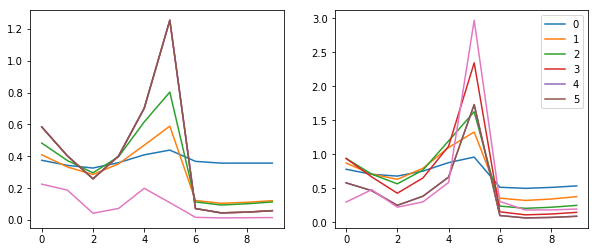

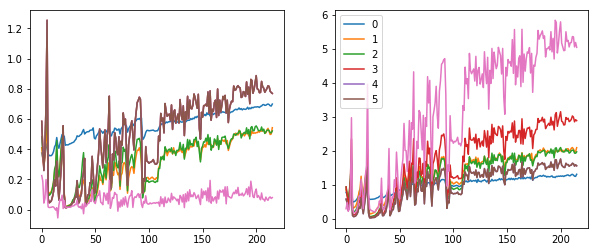

In [156]:
with Hooks(model, append_stats) as hooks:
    run.fit(2, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(6));

### Other Statistics

Let's store more than the means and stds and plot histograms of our activations now.

In [157]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    means,stds,hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds .append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(40,0,10)) #histc isn't implemented on the GPU

In [158]:
model = get_cnn_model(data, nfs).cuda()
learn, run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [159]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [160]:
with Hooks(model, append_stats) as hooks: run.fit(1, learn)

train: [1.77242171875, tensor(0.3911, device='cuda:0')]
valid: [0.657517041015625, tensor(0.7820, device='cuda:0')]


In [161]:
# Thanks to @ste for initial version of histgram plotting code
def get_hist(h): 
    return torch.stack(h.stats[2]).t().float().log1p()

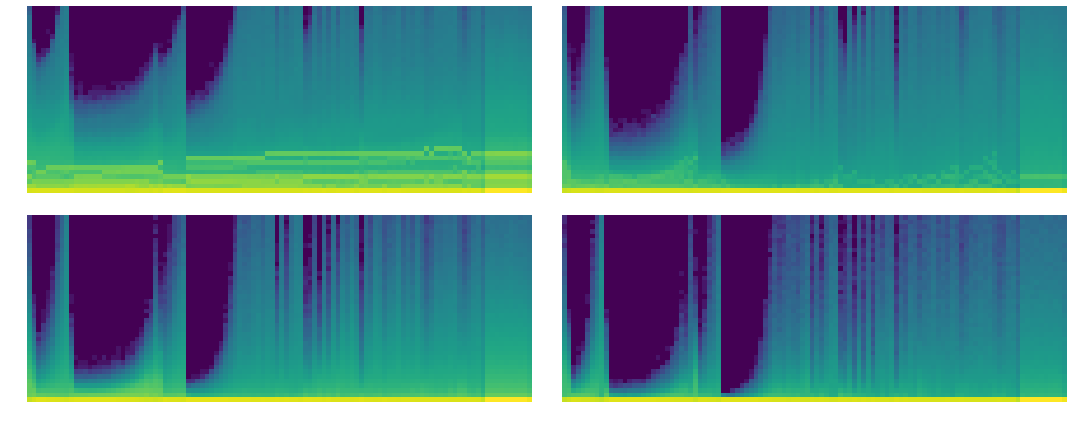

In [162]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

Let's investigate our activations being zero.

From the histograms, we can easily get more informations like the min or max of the activations

In [163]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[:2].sum(0)/h1.sum(0)

In [164]:
# fig,axes = plt.subplots(2,2, figsize=(15,6))
# for ax,h in zip(axes.flatten(), hooks[:4]):
#     ax.plot(get_min(h))
#     ax.set_ylim(0,1)
# plt.tight_layout()

Almost 90% of our activations are zero and we don't want that.

## Generalized ReLU

In [165]:
def get_cnn_layers(data, nfs, layer, **kwargs):
    nfs = [1] + nfs
    return [layer(nfs[i], nfs[i+1], 5 if i==0 else 3, **kwargs)
            for i in range(len(nfs)-1)] + [
        nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def conv_layer(ni, nf, ks=3, stride=2, **kwargs):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), GeneralRelu(**kwargs))

class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv

    def forward(self, x): 
        x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x.sub_(self.sub)
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    for l in m:
        if isinstance(l, nn.Sequential):
            f(l[0].weight, a=0.1)
            l[0].bias.data.zero_()

def get_cnn_model(data, nfs, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))

In [166]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    means,stds,hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds .append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(40,-7,7))

In [167]:
model =  get_cnn_model(data, nfs, conv_layer, leak=0.1, sub=0.4, maxv=6.)
init_cnn(model)
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

train: [0.520691640625, tensor(0.8343, device='cuda:0')]
valid: [0.2457564453125, tensor(0.9281, device='cuda:0')]


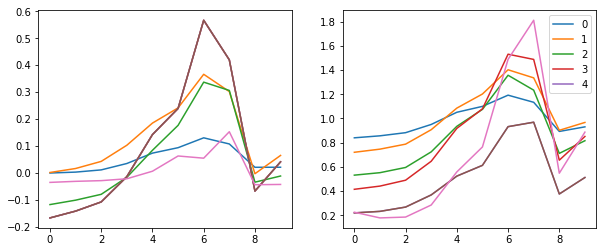

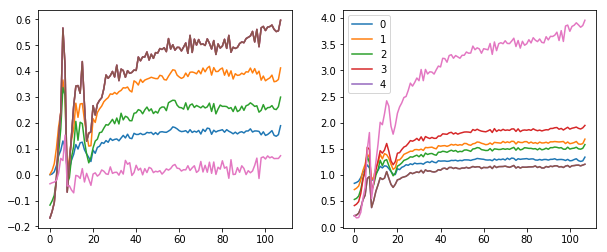

In [168]:
with Hooks(model, append_stats) as hooks:
    run.fit(1, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss,hi = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(5));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss,hi = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(5));

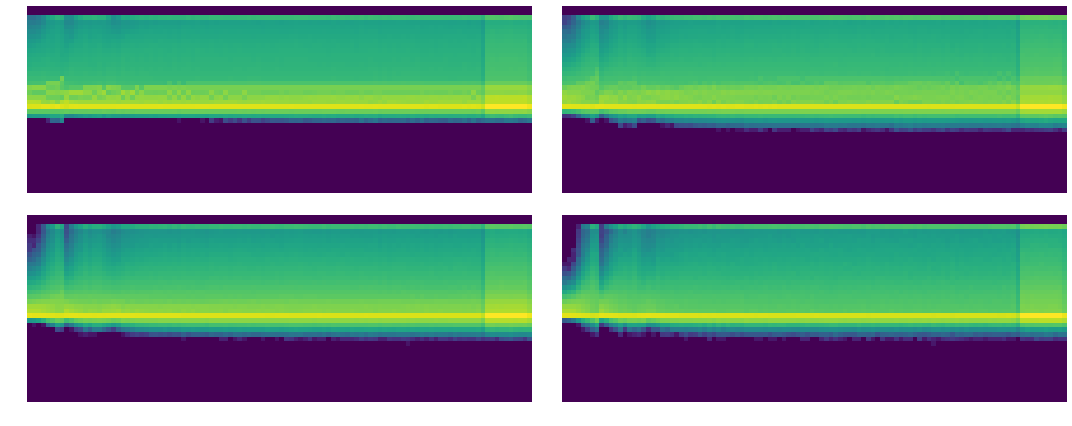

In [169]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

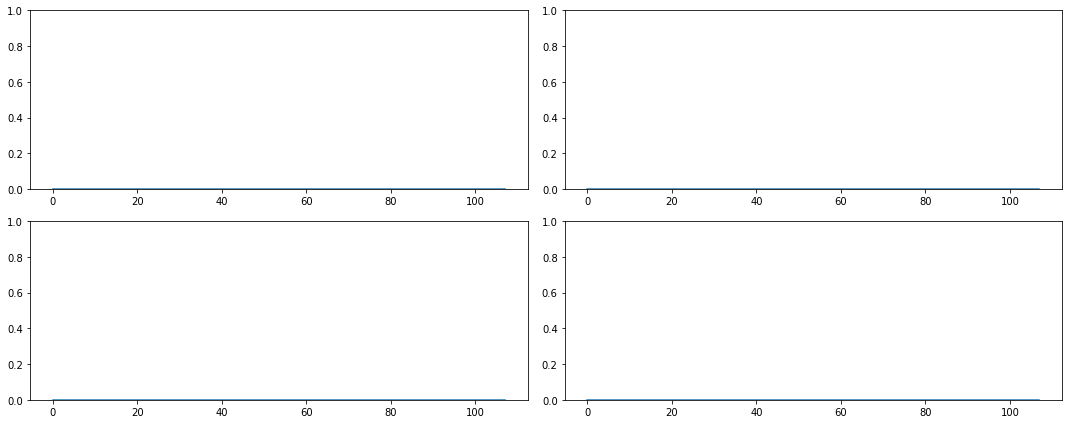

In [172]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

In [173]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[19:22].sum(0)/h1.sum(0)

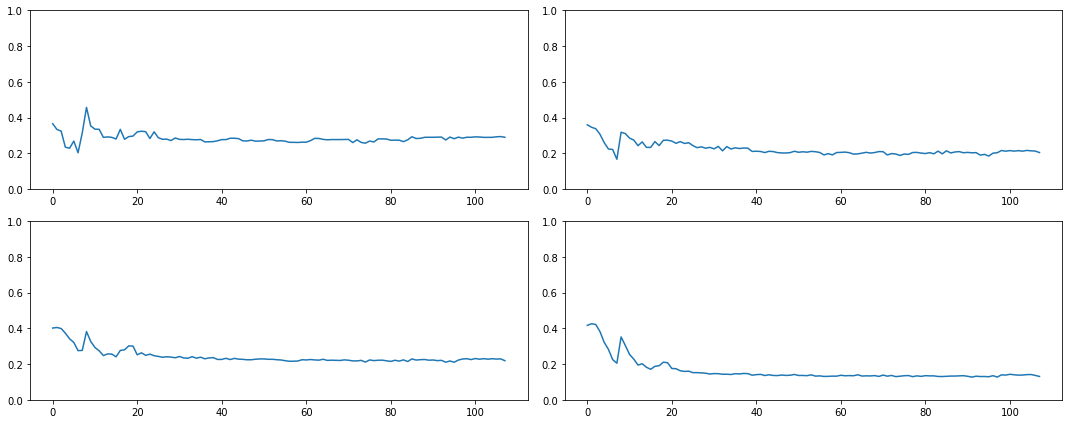

In [174]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

In [175]:
def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [176]:
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    pcts = tensor([0] + listify(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

In [177]:
import math

def annealer(f):
    def _inner(start, end): 
        return partial(f, start, end)
    return _inner

@annealer
def sched_lin(start, end, pos): 
    return start + pos*(end-start)
@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2
@annealer
def sched_no(start, end, pos):  return start
@annealer
def sched_exp(start, end, pos): return start * (end/start) ** pos

def cos_1cycle_anneal(start, high, end):
    return [sched_cos(start, high), sched_cos(high, end)]

#This monkey-patch is there to be able to plot tensors
torch.Tensor.ndim = property(lambda x: len(x.shape))

class Recorder(Callback):
    def begin_fit(self): self.lrs,self.losses = [],[]

    def after_batch(self):
        if not self.in_train: return
        self.lrs.append(self.opt.param_groups[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self): plt.plot(self.lrs)
    def plot_loss(self): plt.plot(self.losses)

class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_func): self.pname,self.sched_func = pname,sched_func

    def set_param(self):
        for pg in self.opt.param_groups:
            pg[self.pname] = self.sched_func(self.n_epochs/self.epochs)
            
    def begin_batch(self): 
        if self.in_train: self.set_param()

In [178]:
sched = combine_scheds([0.5, 0.5], [sched_cos(0.2, 1.), sched_cos(1., 0.1)]) 

In [179]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs+[partial(ParamScheduler,'lr', sched)])

In [180]:
run.fit(8, learn)

train: [1.060915234375, tensor(0.6694, device='cuda:0')]
valid: [0.493050634765625, tensor(0.8412, device='cuda:0')]
train: [0.32353591796875, tensor(0.9018, device='cuda:0')]
valid: [0.1593845947265625, tensor(0.9519, device='cuda:0')]
train: [0.2440578515625, tensor(0.9274, device='cuda:0')]
valid: [0.13114432373046875, tensor(0.9624, device='cuda:0')]
train: [0.11478775390625, tensor(0.9652, device='cuda:0')]
valid: [0.11049580078125, tensor(0.9680, device='cuda:0')]
train: [0.0975326953125, tensor(0.9700, device='cuda:0')]
valid: [0.08416253051757812, tensor(0.9740, device='cuda:0')]
train: [0.05666337890625, tensor(0.9827, device='cuda:0')]
valid: [0.0691174072265625, tensor(0.9798, device='cuda:0')]
train: [0.0409935302734375, tensor(0.9870, device='cuda:0')]
valid: [0.062134423828125, tensor(0.9820, device='cuda:0')]
train: [0.03323422119140625, tensor(0.9896, device='cuda:0')]
valid: [0.06214251708984375, tensor(0.9826, device='cuda:0')]


Uniform init may provide added value since it doesn't put many weights at 0 like normal init:

In [181]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, uniform=True,
                          cbs=cbfs+[partial(ParamScheduler,'lr', sched)])

In [182]:
run.fit(8, learn)

train: [1.253315546875, tensor(0.5888, device='cuda:0')]
valid: [0.36798681640625, tensor(0.8881, device='cuda:0')]
train: [0.3452720703125, tensor(0.8970, device='cuda:0')]
valid: [0.19749097900390625, tensor(0.9400, device='cuda:0')]
train: [0.24668892578125, tensor(0.9262, device='cuda:0')]
valid: [0.1775989501953125, tensor(0.9451, device='cuda:0')]
train: [0.129861171875, tensor(0.9596, device='cuda:0')]
valid: [0.089367822265625, tensor(0.9743, device='cuda:0')]
train: [0.0806864111328125, tensor(0.9745, device='cuda:0')]
valid: [0.07527806396484375, tensor(0.9782, device='cuda:0')]
train: [0.055491279296875, tensor(0.9824, device='cuda:0')]
valid: [0.06677013549804688, tensor(0.9803, device='cuda:0')]
train: [0.0411886376953125, tensor(0.9877, device='cuda:0')]
valid: [0.05997559204101562, tensor(0.9825, device='cuda:0')]
train: [0.0339090625, tensor(0.9901, device='cuda:0')]
valid: [0.0596075439453125, tensor(0.9827, device='cuda:0')]


---

# ConvNet

In [183]:
x_train,y_train,x_valid,y_valid = get_data()
x_train,x_valid = normalize_to(x_train,x_valid)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [184]:
mnist_view = view_tfm(1,28,28)
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        CudaCallBack,
        partial(BatchTransformXCallback, mnist_view)]

In [185]:
nfs = [8,16,32,64,64]

In [186]:
learn, run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [187]:
%time run.fit(2, learn)

train: [1.48314390625, tensor(0.5126, device='cuda:0')]
valid: [0.2979984619140625, tensor(0.9098, device='cuda:0')]
train: [0.2393195703125, tensor(0.9277, device='cuda:0')]
valid: [0.16126219482421875, tensor(0.9515, device='cuda:0')]
CPU times: user 2.05 s, sys: 680 ms, total: 2.73 s
Wall time: 2.4 s


## Batchnorm

Let's start by building our own `Batchnorm` layer from scratch.

In [188]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        # NB: pytorch bn mom is opposite of what you'd expect
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('vars',  torch.ones(1,nf,1,1))
        self.register_buffer('means', torch.zeros(1,nf,1,1))

    def update_stats(self, x):
        m = x.mean((0,2,3), keepdim=True)
        v = x.var ((0,2,3), keepdim=True)
        self.means.lerp_(m, self.mom)
        self.vars.lerp_ (v, self.mom)
        return m,v
        
    def forward(self, x):
        if self.training:
            with torch.no_grad(): m,v = self.update_stats(x)
        else: m,v = self.means,self.vars
        x = (x-m) / (v+self.eps).sqrt()
        return x*self.mults + self.adds

In [189]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    # No bias needed if using bn
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(BatchNorm(nf))
    return nn.Sequential(*layers)

In [190]:
def init_cnn_(m, f):
    if isinstance(m, nn.Conv2d):
        f(m.weight, a=0.1)
        if getattr(m, 'bias', None) is not None: m.bias.data.zero_()
    for l in m.children(): init_cnn_(l, f)

def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    init_cnn_(m, f)

def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

We can then use it in training and see how it helps keep the activations means to 0 and the std to 1.

In [191]:
learn, run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs)

In [196]:
# with Hooks(learn.model, append_stats) as hooks:
#     run.fit(1, learn)
#     fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
#     for h in hooks[:-1]:
#         ms,ss = h.stats
#         ax0.plot(ms[:10])
#         ax1.plot(ss[:10])
#         h.remove()
#     plt.legend(range(6));
    
#     fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
#     for h in hooks[:-1]:
#         ms,ss = h.stats
#         ax0.plot(ms)
#         ax1.plot(ss)

In [197]:
learn,run = get_learn_run(nfs, data, 1.0, conv_layer, cbs=cbfs)

In [198]:
%time run.fit(3, learn)

train: [0.25269798828125, tensor(0.9219, device='cuda:0')]
valid: [0.1530221435546875, tensor(0.9537, device='cuda:0')]
train: [0.0849437109375, tensor(0.9734, device='cuda:0')]
valid: [0.09541368408203126, tensor(0.9688, device='cuda:0')]
train: [0.0598129296875, tensor(0.9810, device='cuda:0')]
valid: [0.1203537109375, tensor(0.9625, device='cuda:0')]
CPU times: user 3.45 s, sys: 412 ms, total: 3.86 s
Wall time: 3.88 s


### Builtin Batchnorm

In [199]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [200]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs)

In [201]:
%time run.fit(3, learn)

train: [0.26425353515625, tensor(0.9214, device='cuda:0')]
valid: [0.10408934326171874, tensor(0.9680, device='cuda:0')]
train: [0.074472373046875, tensor(0.9769, device='cuda:0')]
valid: [0.07626646118164063, tensor(0.9767, device='cuda:0')]
train: [0.0511612646484375, tensor(0.9843, device='cuda:0')]
valid: [0.069636962890625, tensor(0.9786, device='cuda:0')]
CPU times: user 3.07 s, sys: 460 ms, total: 3.53 s
Wall time: 3.55 s


### With Scheduler

Now let's add the usual warmup/annealing:

In [202]:
sched = combine_scheds([0.3, 0.7], [sched_lin(0.6, 2.), sched_lin(2., 0.1)]) 

In [203]:
learn,run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs
                          +[partial(ParamScheduler,'lr', sched)])

In [204]:
run.fit(8, learn)

train: [0.3423046484375, tensor(0.8957, device='cuda:0')]
valid: [0.13684195556640624, tensor(0.9587, device='cuda:0')]
train: [0.104302275390625, tensor(0.9666, device='cuda:0')]
valid: [0.0806655029296875, tensor(0.9770, device='cuda:0')]
train: [0.0663425537109375, tensor(0.9785, device='cuda:0')]
valid: [0.06987247924804688, tensor(0.9783, device='cuda:0')]
train: [0.0442214599609375, tensor(0.9863, device='cuda:0')]
valid: [0.07664190673828125, tensor(0.9768, device='cuda:0')]
train: [0.0299293212890625, tensor(0.9907, device='cuda:0')]
valid: [0.05306869506835937, tensor(0.9820, device='cuda:0')]
train: [0.01963597412109375, tensor(0.9944, device='cuda:0')]
valid: [0.04799787902832031, tensor(0.9851, device='cuda:0')]
train: [0.012680633544921875, tensor(0.9968, device='cuda:0')]
valid: [0.044890817260742184, tensor(0.9867, device='cuda:0')]
train: [0.00894314697265625, tensor(0.9982, device='cuda:0')]
valid: [0.04442623291015625, tensor(0.9873, device='cuda:0')]


Batchnorm is really quite fantastic.

## More Norms

### Layer Norm

Batch norm has the following deficiencies:

- How do we handle very small batch size (where variance converges to 0).
- How do we use BatchNorm in RNNs.

In [205]:
class LayerNorm(nn.Module):
    __constants__ = ['eps']
    def __init__(self, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.))
        self.add  = nn.Parameter(tensor(0.))

    def forward(self, x):
        m = x.mean((1,2,3), keepdim=True)
        v = x.var ((1,2,3), keepdim=True)
        x = (x-m) / ((v+self.eps).sqrt())
        return x*self.mult + self.add

We remove all of the running averages. We're not taking the mean of the batch anymore, every image has its own mean and standard diviation.

In [206]:
def conv_ln(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if bn: layers.append(LayerNorm())
    return nn.Sequential(*layers)

In [207]:
learn,run = get_learn_run(nfs, data, 0.8, conv_ln, cbs=cbfs)

In [208]:
%time run.fit(3, learn)

train: [nan, tensor(0.1123, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
CPU times: user 3.86 s, sys: 496 ms, total: 4.35 s
Wall time: 4.37 s


Layer norm is not as good as batchnorm but it's the only option you have for online learning or RNN networks.

### Instance Norm

The key difference between **contrast** and batch normalization is that the latter applies the normalization to a  whole batch of images instead for single ones:

\begin{equation}\label{eq:bnorm}
    y_{tijk} =  \frac{x_{tijk} - \mu_{i}}{\sqrt{\sigma_i^2 + \epsilon}},
    \quad
    \mu_i = \frac{1}{HWT}\sum_{t=1}^T\sum_{l=1}^W \sum_{m=1}^H x_{tilm},
    \quad
    \sigma_i^2 = \frac{1}{HWT}\sum_{t=1}^T\sum_{l=1}^W \sum_{m=1}^H (x_{tilm} - mu_i)^2.
\end{equation}

In order to combine the effects of instance-specific normalization and batch normalization, we propose to replace the latter by the *instance normalization* (also known as *contrast normalization*) layer:

\begin{equation}\label{eq:inorm}
    y_{tijk} =  \frac{x_{tijk} - \mu_{ti}}{\sqrt{\sigma_{ti}^2 + \epsilon}},
    \quad
    \mu_{ti} = \frac{1}{HW}\sum_{l=1}^W \sum_{m=1}^H x_{tilm},
    \quad
    \sigma_{ti}^2 = \frac{1}{HW}\sum_{l=1}^W \sum_{m=1}^H (x_{tilm} - mu_{ti})^2.
\end{equation}

In [209]:
class InstanceNorm(nn.Module):
    __constants__ = ['eps']
    def __init__(self, nf, eps=1e-0):
        super().__init__()
        self.eps = eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))

    def forward(self, x):
        m = x.mean((2,3), keepdim=True)
        v = x.var ((2,3), keepdim=True)
        res = (x-m) / ((v+self.eps).sqrt())
        return res*self.mults + self.adds

In [210]:
def conv_in(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if bn: layers.append(InstanceNorm(nf))
    return nn.Sequential(*layers)

In [211]:
learn,run = get_learn_run(nfs, data, 0.1, conv_in, cbs=cbfs)

In [212]:
%time run.fit(3, learn)

train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
CPU times: user 3.85 s, sys: 516 ms, total: 4.36 s
Wall time: 4.38 s


### Group Norm

A more general way of doing activation normalization.

`GroupNorm(num_groups, num_channels, eps=1e-5, affine=True)`

The input channels are separated into `num_groups` groups, each containing
``num_channels / num_groups`` channels. The mean and standard-deviation are calculated
separately over the each group. $\gamma$ and $\beta$ are learnable
per-channel affine transform parameter vectorss of size `num_channels` if
`affine` is ``True``.

This layer uses statistics computed from input data in both training and
evaluation modes.

Args:
-    num_groups (int): number of groups to separate the channels into
-    num_channels (int): number of channels expected in input
-    eps: a value added to the denominator for numerical stability. Default: 1e-5
-    affine: a boolean value that when set to ``True``, this module
        has learnable per-channel affine parameters initialized to ones (for weights)
        and zeros (for biases). Default: ``True``.

Shape:
- Input: `(N, num_channels, *)`
- Output: `(N, num_channels, *)` (same shape as input)

Examples::

    >>> input = torch.randn(20, 6, 10, 10)
    >>> # Separate 6 channels into 3 groups
    >>> m = nn.GroupNorm(3, 6)
    >>> # Separate 6 channels into 6 groups (equivalent with InstanceNorm)
    >>> m = nn.GroupNorm(6, 6)
    >>> # Put all 6 channels into a single group (equivalent with LayerNorm)
    >>> m = nn.GroupNorm(1, 6)
    >>> # Activating the module
    >>> output = m(input)

## Fix small batch sizes

### What's the Problem

As the batch size gets smaller, its variance converges to 0 (the data points get closer to the mean).  

In [213]:
data = DataBunch(*get_dls(train_ds, valid_ds, 2), c)

In [214]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [215]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [216]:
%time run.fit(1, learn)

train: [2.34630625, tensor(0.1759, device='cuda:0')]
valid: [61394.6176, tensor(0.2345, device='cuda:0')]
CPU times: user 1min 28s, sys: 552 ms, total: 1min 28s
Wall time: 1min 30s


### Running Batchnorm

To solve this problem we introduce a Running BatchNorm that uses smoother running mean and variance for the mean and std.

In [217]:
class RunningBatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('sums', torch.zeros(1,nf,1,1))
        self.register_buffer('sqrs', torch.zeros(1,nf,1,1))
        self.register_buffer('batch', tensor(0.))
        self.register_buffer('count', tensor(0.))
        self.register_buffer('step', tensor(0.))
        self.register_buffer('dbias', tensor(0.))

    def update_stats(self, x):
        bs,nc,*_ = x.shape
        self.sums.detach_()
        self.sqrs.detach_()
        dims = (0,2,3)
        s = x.sum(dims, keepdim=True)
        ss = (x*x).sum(dims, keepdim=True)
        c = self.count.new_tensor(x.numel()/nc)
        mom1 = 1 - (1-self.mom)/math.sqrt(bs-1)
        self.mom1 = self.dbias.new_tensor(mom1)
        self.sums.lerp_(s, self.mom1)
        self.sqrs.lerp_(ss, self.mom1)
        self.count.lerp_(c, self.mom1)
        self.dbias = self.dbias*(1-self.mom1) + self.mom1
        self.batch += bs
        self.step += 1

    def forward(self, x):
        if self.training: self.update_stats(x)
        sums = self.sums
        sqrs = self.sqrs
        c = self.count
        if self.step<100:
            sums = sums / self.dbias
            sqrs = sqrs / self.dbias
            c    = c    / self.dbias
        means = sums/c
        vars = (sqrs/c).sub_(means*means)
        if bool(self.batch < 20): vars.clamp_min_(0.01)
        x = (x-means).div_((vars.add_(self.eps)).sqrt())
        return x.mul_(self.mults).add_(self.adds)

In [218]:
def conv_rbn(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(RunningBatchNorm(nf))
    return nn.Sequential(*layers)

In [219]:
learn,run = get_learn_run(nfs, data, 0.4, conv_rbn, cbs=cbfs)

In [220]:
%time run.fit(1, learn)

train: [0.5531725390625, tensor(0.8519, device='cuda:0')]
valid: [0.232340380859375, tensor(0.9525, device='cuda:0')]
CPU times: user 3min 42s, sys: 1.25 s, total: 3min 43s
Wall time: 3min 45s


## What can we do in a single epoch?

Now let's see with a decent batch size what can we get.

In [221]:
data = DataBunch(*get_dls(train_ds, valid_ds, 32), c)

In [222]:
learn,run = get_learn_run(nfs, data, 0.9, conv_rbn, cbs=cbfs
                          +[partial(ParamScheduler,'lr', sched_lin(1., 0.2))])

In [ ]:
%time run.fit(1, learn)

---